### Cross validation over PHUS

We are asuming that all the observations within the stations from the same PHU are 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from gee_scripts.parameters import explain_vars, response_var, west_region_ids, center_region_ids
from scipy.stats import pearsonr
from gee_scripts.models import get_random_forest, get_regressors
import tensorflow as tf
from sklearn.discriminant_analysis import StandardScaler
from gee_scripts.models import split_dataset


Earth Engine initialized successfully, with ee-indonesia-gwl


2024-06-19 17:05:14.873919: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 17:05:14.875508: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 17:05:14.904438: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 17:05:14.905140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 17:05:15.413774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
# # split the training_df into training and test where test is the last year

# # Train by year
# # train_data = train_df[train_df["date"].dt.year.isin([2020,2021,2022])]
# # test_data = train_df[train_df["date"].dt.year.isin([2023])]

# # # train and test selection by month
# # train_data = train_df[train_df["date"].dt.month.isin([1,2,4,5,7,8,10,11,12])]
# # test_data = train_df[train_df["date"].dt.month.isin([3,6,9])]

# X_train, X_test = train_data[explain_vars], test_data[explain_vars]
# y_train, y_test = train_data["gwl_cm"], test_data["gwl_cm"]

# print("lenght of train and test", len(X_train), len(X_test))

# ####################### TRAIN THE MODEL ############################

# regr.fit(X_train, y_train)
# y_pred_test = regr.predict(X_test)

# r, p = pearsonr(y_test, y_pred_test)
# r2_score_val = r2_score(y_test, y_pred_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# # print all the metrics
# print(f"r2_score: {r2_score_val}")
# print(f"rmse: {rmse}")
# print(f"pearson r: {r}")
# print(f"p-value: {p}")

# # Plot the observed vs predicted with labels and title
# plt.scatter(y_test, y_pred_test)
# plt.xlabel("Observed")
# plt.ylabel("Predicted")
# plt.title("Observed vs Predicted")
# plt.show()

# 1. Read training data

In [4]:
center_region_ids

[7, 8, 10]

In [5]:
df = pd.read_csv("data/9_clean_training_data/all_training_data_with_extra_and_locations_and_precipSum.csv", parse_dates=["date"])

assert len(df) == 32783, "The length of the dataframe is not correct"

df = df[df.region_id.isin(center_region_ids)]

assert df[["date"]].dtypes.iloc[0] == "datetime64[ns]"
len(df)

# Add cluster_id to the dataframe
# kalimantan_clusters = pd.read_csv("data/14_featureEngineering/kalimantan_4clusters.csv")
# df = df.merge(kalimantan_clusters, on="id")
# explain_vars = explain_vars + ["cluster"]

6063

In [7]:
# pd.DataFrame(df.id.unique(), columns=["station_id"]).to_csv("data/kalimantan_station_ids.csv", index=False)

In [8]:
# filter_condition = df.phu_id==71
# train_df = df[filter_condition]
# len(train_df)

<Axes: xlabel='region_id', ylabel='gwl_cm'>

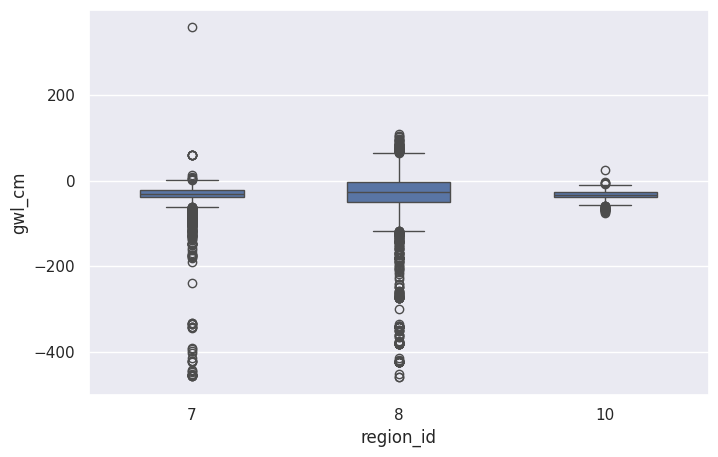

In [9]:
import seaborn as sns
# get a boxplot of response var per region but use a small graph size

# set the seaborn style and size
sns.set_style("whitegrid");
sns.set(rc={'figure.figsize':(8,5)});
sns.boxplot(x="region_id", y="gwl_cm", data=df, width=0.5)

<Axes: xlabel='date', ylabel='gwl_cm'>

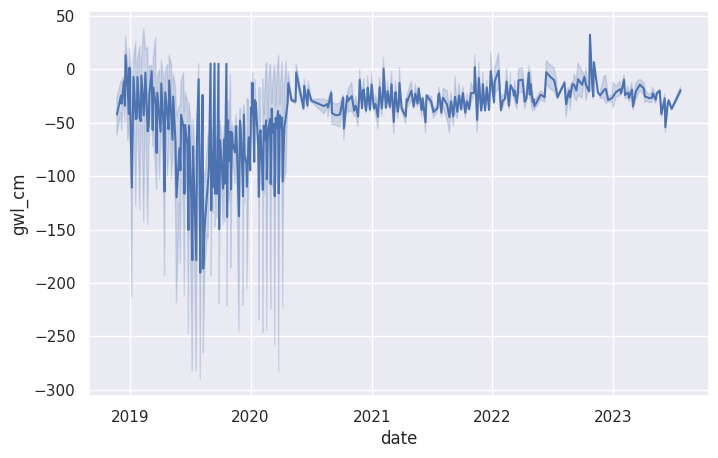

In [10]:
sns.lineplot(x="date", y="gwl_cm", data=df)


In [ ]:
# # Get a table with the count of the number of observations per month
# train_df["month"] = train_df["date"].dt.month
# train_df["year"] = train_df["date"].dt.year
# train_df["month_year"] = train_df["date"].dt.to_period('M')
# train_df[train_df.id == "15_RAPP_LGBI-001a"].groupby("month_year").size().reset_index(name='counts')

In [ ]:
# train_df["date"] = pd.to_datetime(train_df["date"])
# get_precipitation_plot(train_df, group_by="station", value="15_RAPP_LGBI-001a")

In [ ]:
# # group by id and get the number of dates for each id
# group_by = "id"
# df_grouped = train_df.groupby(group_by).count().reset_index()
# df_grouped = df_grouped[[group_by, "date"]]
# df_grouped.columns = ["name", "date_count"]
# df_grouped.sort_values(by="date_count", ascending=False);

In [ ]:
# # drop all stations with less tan 9 observations
# min_obs = 0
# train_df.groupby('id').agg({'date': 'count'}).sort_values(by='date', ascending=False).reset_index()
# train_df = train_df.groupby('id').filter(lambda group: len(group) >= min_obs)

In [ ]:
# running cross validation on 23 phu_ids
# processing phu_id 407.0 with No. of observations 199
# Splitting by station with 34 categories

In [11]:
def evaluate_models(data, target_column, n_splits):
    """Evaluate the performance of different regression models on the dataset using cross-validation."""

    data = data.copy()

    results = []
    
    # Loop through each split type
    for split_type in ["station", "year", "month"]:
        
        train_test_splits = split_dataset(data, by=split_type, n_splits=n_splits)

        if split_type == "station":
            split_type = "id"

        for train_data, test_data in train_test_splits:

            if len(test_data) == 0:
                results.append({
                    "phu_id": data["phu_id"].iloc[0],
                    "split_type": split_type,
                    "no_obs": len(data),
                    "train_obs": 0,
                    "test_obs": 0,
                    "estimator_name": None,
                    "validation" : f"cross validation {split_type}",
                    "test_ids": None,
                    "train_ids": None,
                    "r2_score": None,
                    "rmse": None,
                    "pearson_r": None,
                    "p_value": None,
                })
                continue
            
            X_train, X_test = train_data[explain_vars], test_data[explain_vars]
            y_train, y_test = train_data[target_column], test_data[target_column]

            input_dim = X_train.shape[1]  # Number of explanatory variables

            for regr in get_regressors(input_dim):
                print(f"Training {regr.__class__.__name__} on {len(train_data)} observations and testing on {len(test_data)} observations")

                if isinstance(regr, tf.keras.Model):  # Check if the model is a Keras model
                    # Neural network requires normalization and batch processing
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train)
                    X_test_scaled = scaler.transform(X_test)
                    
                    # Fit the model
                    regr.fit(X_train_scaled, y_train, epochs=5, batch_size=8, verbose=0)
                    
                    # Predict
                    y_pred_test = regr.predict(X_test_scaled).flatten()  # Flatten to convert 2D predictions to 1D
                else:
                    # Fit traditional models
                    regr.fit(X_train, y_train)
                    
                    # Predict
                    y_pred_test = regr.predict(X_test)


                r, p = pearsonr(y_test, y_pred_test)
                r2_score_val = r2_score(y_test, y_pred_test)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

                results.append({
                    "phu_id": train_data["phu_id"].iloc[0],
                    "no_obs": len(data),
                    "train_obs": len(train_data),
                    "test_obs": len(test_data),
                    "estimator_name": regr.__class__.__name__,
                    "validation" : f"cross validation {split_type}",
                    "train_ids": train_data[split_type].unique(),
                    "test_ids": test_data[split_type].unique(),
                    "r2_score": r2_score_val,
                    "rmse": rmse,
                    "pearson_r": r,
                    "p_value": p,
                })

    return results

In [12]:
df.phu_id.unique()

array([407.,  nan, 404., 375., 256., 340., 352., 371., 314., 297., 253.,
       229., 239., 219., 308., 370., 356., 350., 361., 351., 357., 381.,
       379., 382.])

In [13]:
sorted([(id_, len(df[df.phu_id == id_])) for id_ in df.phu_id.unique()], key=lambda x: x[0])

[(407.0, 200),
 (nan, 0),
 (219.0, 20),
 (229.0, 26),
 (239.0, 126),
 (253.0, 38),
 (256.0, 849),
 (297.0, 159),
 (308.0, 157),
 (314.0, 40),
 (340.0, 1546),
 (350.0, 481),
 (351.0, 1007),
 (352.0, 276),
 (356.0, 18),
 (357.0, 173),
 (361.0, 27),
 (370.0, 20),
 (371.0, 280),
 (375.0, 182),
 (379.0, 152),
 (381.0, 46),
 (382.0, 12),
 (404.0, 224)]

In [14]:
%%time
phu_cross_validation_results = []
failed_phus = []
errors = {}

print(f"running cross validation on {df.phu_id.nunique()} phu_ids")

for phu_id in df.phu_id.unique():
    if  pd.isnull(phu_id):
        print("Skipping phu_id", phu_id, "because it is null")
        continue
    print("processing phu_id", phu_id, "with No. of observations", len(df[df.phu_id==phu_id]))
    filter_condition = df.phu_id==phu_id
    train_df = df[filter_condition]
    try:
        results = evaluate_models(train_df, "gwl_cm", n_splits=10)
        phu_cross_validation_results.extend(results)
    except exception as e:
        print("Failed to train model on phu_id", phu_id)
        errors[phu] = e
        failed_phus.append(phu_id)
    finally:
        continue

running cross validation on 23 phu_ids
processing phu_id 407.0 with No. of observations 200
Splitting by station with 200 samples
Training RandomForestRegressor on 158 observations and testing on 42 observations
Training GradientBoostingRegressor on 158 observations and testing on 42 observations
Training LinearRegression on 158 observations and testing on 42 observations
Training Sequential on 158 observations and testing on 42 observations
2/2 [==============================] - 0s 2ms/step
Training RandomForestRegressor on 149 observations and testing on 51 observations
Training GradientBoostingRegressor on 149 observations and testing on 51 observations
Training LinearRegression on 149 observations and testing on 51 observations
Training Sequential on 149 observations and testing on 51 observations
2/2 [==============================] - 0s 2ms/step
Training RandomForestRegressor on 166 observations and testing on 34 observations
Training GradientBoostingRegressor on 166 observations

In [15]:
# Create a dataframe from the results
results_df = pd.DataFrame(phu_cross_validation_results)
# Sort the results by r2_score and phu_id
results_df.sort_values(by=["r2_score", "phu_id"], ascending=False, inplace=True)
results_df.to_csv("data/13_estimation_results/kalimantan_multiple_models_cross_validation_results_sorted.csv", index=False)

In [ ]:
results_df = pd.read_csv("data/13_estimation_results/center_multiple_models_cross_validation_results_sorted_2.csv")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming phu_cross_validation_results is a list of dictionaries
results_df = pd.DataFrame(results_df)

# Summary statistics
summary_stats = results_df[['r2_score', 'rmse', 'pearson_r']].describe()

# Performance by model type
model_performance = results_df.groupby('estimator_name')[['r2_score', 'rmse', 'pearson_r']].mean()

# Plotting model performance
plt.figure(figsize=(12, 6))
sns.barplot(x='estimator_name', y='r2_score', data=results_df)
plt.title('Average R2 Score by Model Type')
plt.xticks(rotation=45)
plt.show()

# Analyze performance by split type
split_performance = results_df.groupby('split_type')[['r2_score', 'rmse', 'pearson_r']].mean()

# Print the summary statistics and model performance
print(summary_stats)
print(model_performance)
print(split_performance)

# Handle failures
print("Failed PHUs:", failed_phus)


In [ ]:

# PCA TEST

# Divide train and test by PCA and year
# train_data = train_df[train_df.id.isin(pca1_and_pca2_1stq_ids) & train_df["date"].dt.year.isin([2020,2021,2022])]
# test_data = train_df[train_df.id.isin(pca1_and_pca2_1stq_ids) & train_df["date"].dt.year.isin([2023])]

# # Divide train and test by PCA and month
train_data = train_df[train_df.id.isin(pca1_and_pca2_1stq_ids) & (train_df["date"].dt.month.isin([1,2,4,5,7,8,10,11,12]))]
test_data = train_df[train_df.id.isin(pca1_and_pca2_1stq_ids) & (train_df["date"].dt.month.isin([3,6,9]))]


X_train, X_test = train_data[explain_vars], test_data[explain_vars]
y_train, y_test = train_data["gwl_cm"], test_data["gwl_cm"]

print("lenght of train and test", len(X_train), len(X_test))

####################### TRAIN

regr = get_random_forest()

regr.fit(X_train, y_train)
y_pred_test = regr.predict(X_test)

r, p = pearsonr(y_test, y_pred_test)
r2_score_val = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# print all the metrics
print(f"r2_score: {r2_score_val}")
print(f"rmse: {rmse}")
print(f"pearson r: {r}")
print(f"p-value: {p}")

# Plot the observed vs predicted with labels and title
plt.scatter(y_test, y_pred_test)
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Observed vs Predicted")
plt.show()

In [ ]:

print("dependent var", response_var)
print("explanatory lenght", len(explain_vars))
print(explain_vars)

In [ ]:
# bootstrap_result = bootstrap(df = train_df, variable="gwl_cm", iterations=100, train_size=0.8, explain_vars=explain_vars, bootstrap_by="observations")
# bootstrap_result

In [ ]:
# Now I want to test the model on unseen data and see how it performs
from gee_scripts.models import get_random_forest

# train the model on all the data
regressor = get_random_forest()
regressor.fit(train_df[explain_vars], train_df['gwl_cm'])

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 350, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Assume get_regressor() is your function to get the base model
base_model = get_regressor()
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
X_train, y_train = df[explain_vars], df['gwl_cm']
grid_search.fit(X_train, y_train)

In [ ]:
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error


In [ ]:
# Test on unseen data
test_df = df[df.phu_id == 169]
# test_df

In [ ]:

X_test, y_test = test_df[explain_vars], test_df['gwl_cm']

y_pred = regressor.predict(X_test)
r, p = pearsonr(y_test, y_pred)
r


In [ ]:
r2_score(y_test, y_pred)

In [ ]:
test_df

In [ ]:
pd.DataFrame({"y_test": y_test, "y_pred": y_pred})

In [ ]:
pd.DataFrame({"y_test": y_test, "y_pred": y_pred}).plot.scatter(x="y_test", y="y_pred")

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

